In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.cluster import KMeans
from datetime import datetime,timedelta

from scipy.stats import gaussian_kde,norm,t
from arch import arch_model

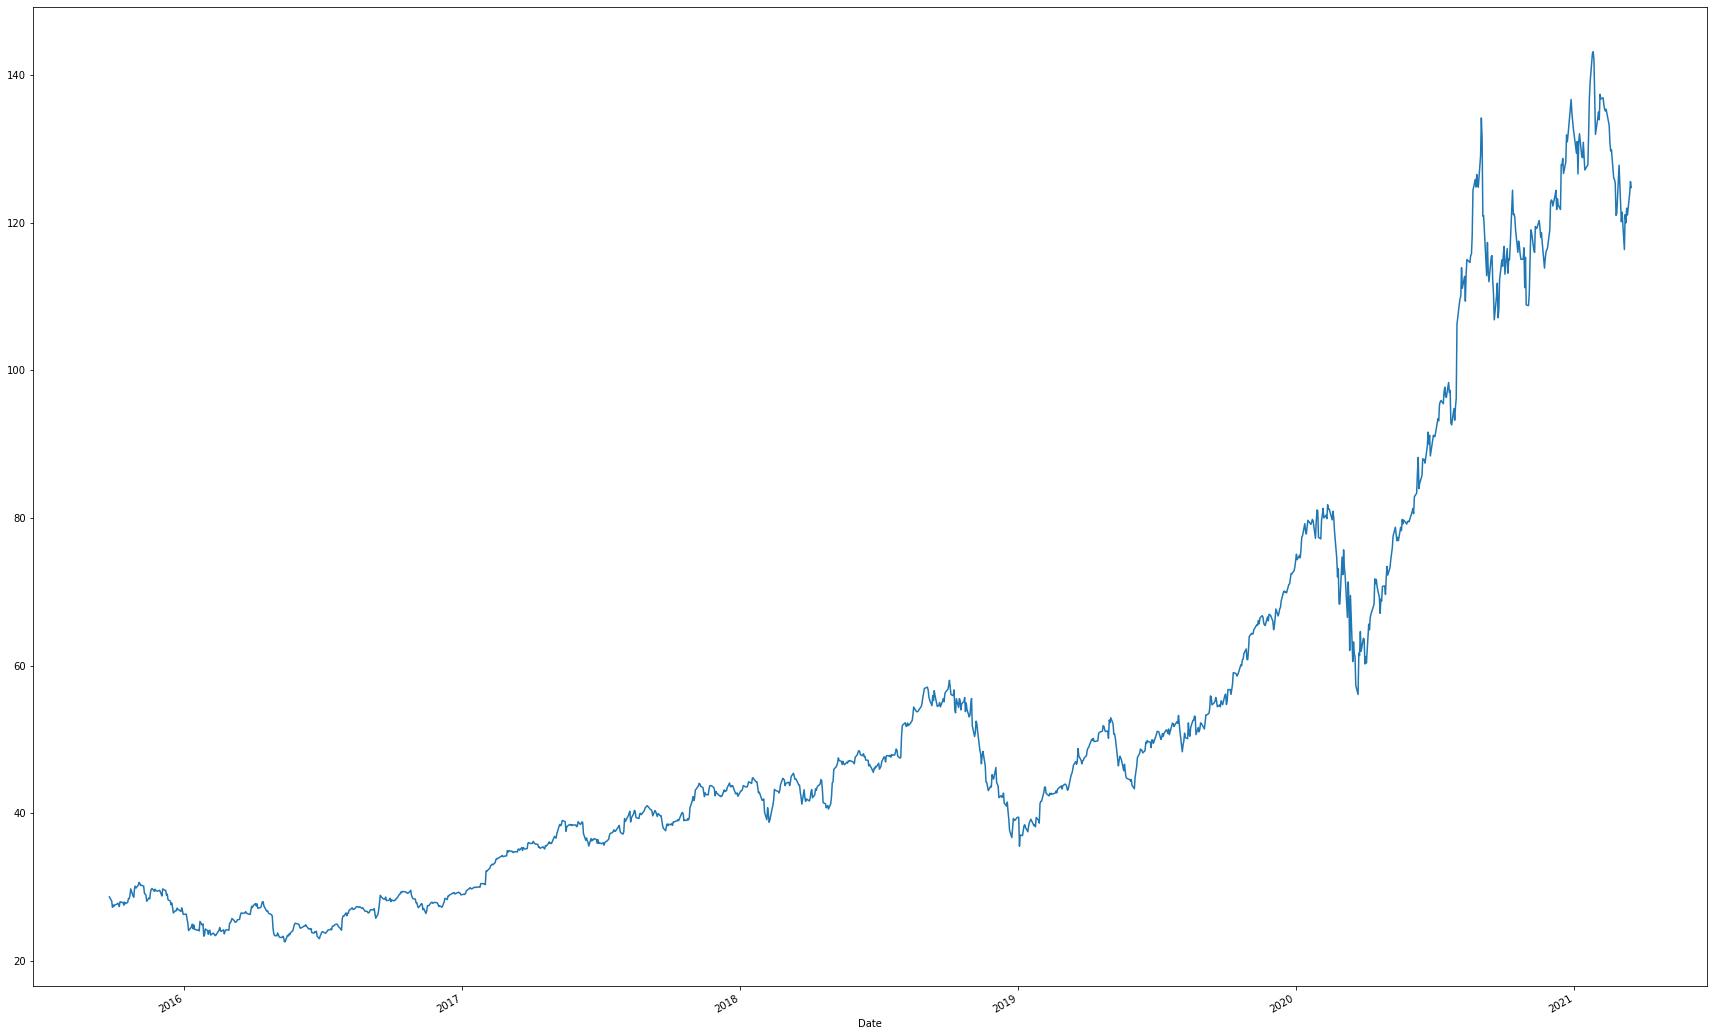

In [2]:
def get_data(ticker):
    ticker = ticker.upper()
    end_date = datetime.today()
    start_date = end_date-timedelta(days=2000) #arbitrary number of days
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')
    df = web.DataReader(ticker,'yahoo',start_date,end_date)
    return df

stock = get_data('AAPL') #Input stock ticker here
stock.Close.plot(figsize=(30, 20))


In [11]:
def plot_trends(x,y,lb):
    plt.figure(figsize=(20,10))
    colors = ['r','orange','g']
    nclasses = len(np.unique(lb))
    for i in range(nclasses):
        xx = x[lb==i]
        yy = y[lb==i]
        plt.scatter(xx,yy,c=colors[i],label=str(i))
    plt.legend(fontsize='x-large')
    plt.show()
    
def get_trends(close,lookback):
    '''
    :type c: ndarray
    :param c: Daily Close prices

    :type lookback: int
    :param lookback: Lookback window for smoothing
    '''
    cs = pd.Series(c)
    ema = cs.ewm(span=lookback).mean()
    ema = ema[::-1].ewm(span=lookback).mean()[::-1]
    ema = ema.values
    
    log_return = np.diff(np.log(ema))        
    algo = KMeans(3).fit(log_return.reshape(-1,1))
    
    lb = algo.labels_
    
    #Change labels to have some semblance of order
    cc = algo.cluster_centers_.flatten()
    temp = [(cc[i],i) for i in range(3)]
    temp = sorted(temp,key=lambda x: x[0])
    
    labels = np.zeros(len(lb),dtype=int)
    for i in range(1,3):
        old_lb = temp[i][1]
        idx = np.where(lb==old_lb)[0]
        labels[idx] = i
        
    x = np.arange(len(labels))
    y = ema[1:]
        
    return x,y,labels

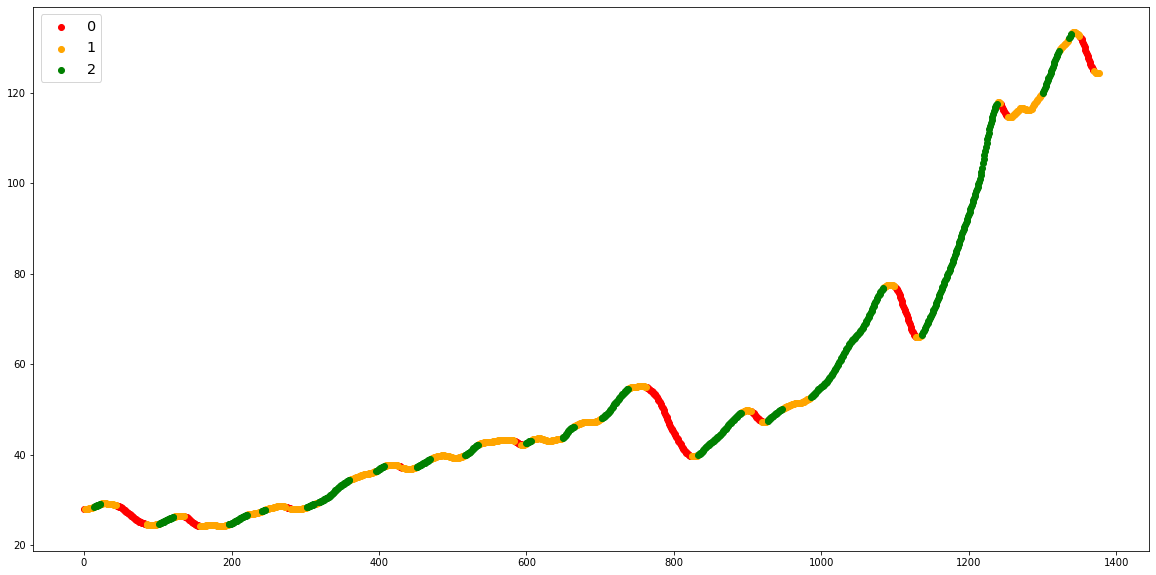

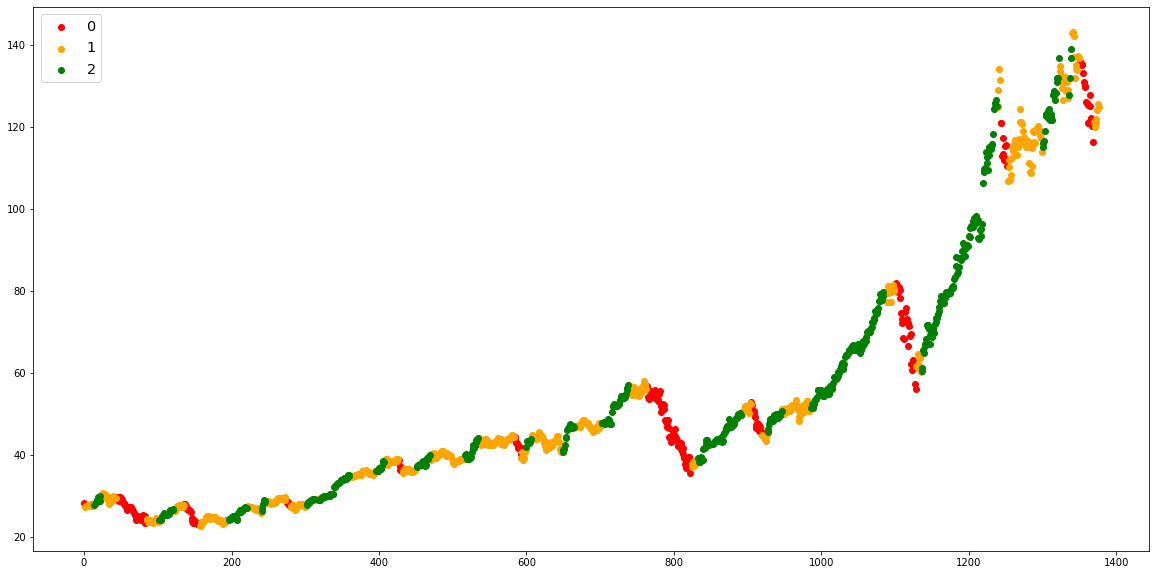

In [12]:
c = stock.Close.values
x,y,lb = get_trends(c,20)
yy = c[1:]

plot_trends(x,y,lb)

#...
plot_trends(x,yy,lb)


In [13]:
lr = np.diff(np.log(c)) #log returns

#Volatility using GARCH(1,1) as we are using daily data. 
def get_volatility(lr):
    gmodel = arch_model(
        lr*100,
        vol='GARCH',
        mean='Zero',
        p=1,
        q=1,
        dist='StudentsT'
        )
    
    gfit = gmodel.fit(update_freq=5)
    vol = gfit.conditional_volatility
    return vol

In [14]:
#Code to get KDE of returns and Tdist/Normal dist of returns
def get_dists(lr,lb):
    kde_dict = dict()
    t_dict = dict()
    norm_dict = dict()
    for i in range(3):
        temp = lr[lb==i]
        xr = np.linspace(lr.min(),lr.max(),1000)  #returns evenly spaced numbers between lr.min() and lr.max() 
        
        kde = gaussian_kde(temp)
        y = kde(xr)
        kde_dict[str(i)] = y
        
        t_pdf = t.pdf(xr,*t.fit(temp))
        n_pdf = norm.pdf(xr,*norm.fit(temp))
        t_dict[str(i)] = t_pdf
        norm_dict[str(i)] = n_pdf
        
    return xr,kde_dict,t_dict,norm_dict


In [23]:
#Plotting Functions
def plot_vol(vol,lb):           #used for plotting volume and volatility
    plt.figure(figsize=(20,10))
    colors = ['r','orange','g']
    for i in range(3):
        temp = vol[lb==i]
        x = np.where(lb==i)[0]
        plt.scatter(x,temp,c=colors[i],label=str(i))
    plt.legend(fontsize='x-large')
    plt.show()

def plot_dists(xr,kde_dict,t_dict,norm_dict):#Used to compare various dists
    
    colors = ['r','orange','g']
    fig,axes = plt.subplots(nrows=3,sharex=True, figsize=(20,10))
    for i in range(3):
        y1,y2,y3 = kde_dict[str(i)],t_dict[str(i)],norm_dict[str(i)]
        axes[0].plot(xr,y1,c=colors[i],label=str(i))
        axes[1].plot(xr,y2,c=colors[i],label=str(i))
        axes[2].plot(xr,y3,c=colors[i],label=str(i))
    plt.legend(fontsize='x-large')
    plt.show()

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3552.964363722754
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2573.2691337369965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2573.2617498410655
            Iterations: 14
            Function evaluations: 80
            Gradient evaluations: 14


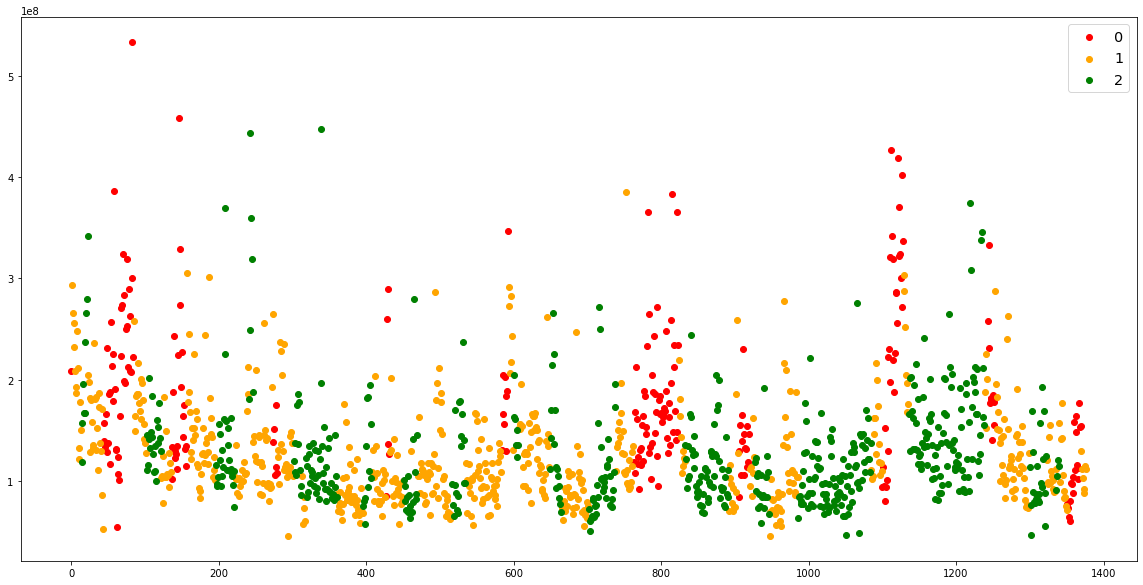

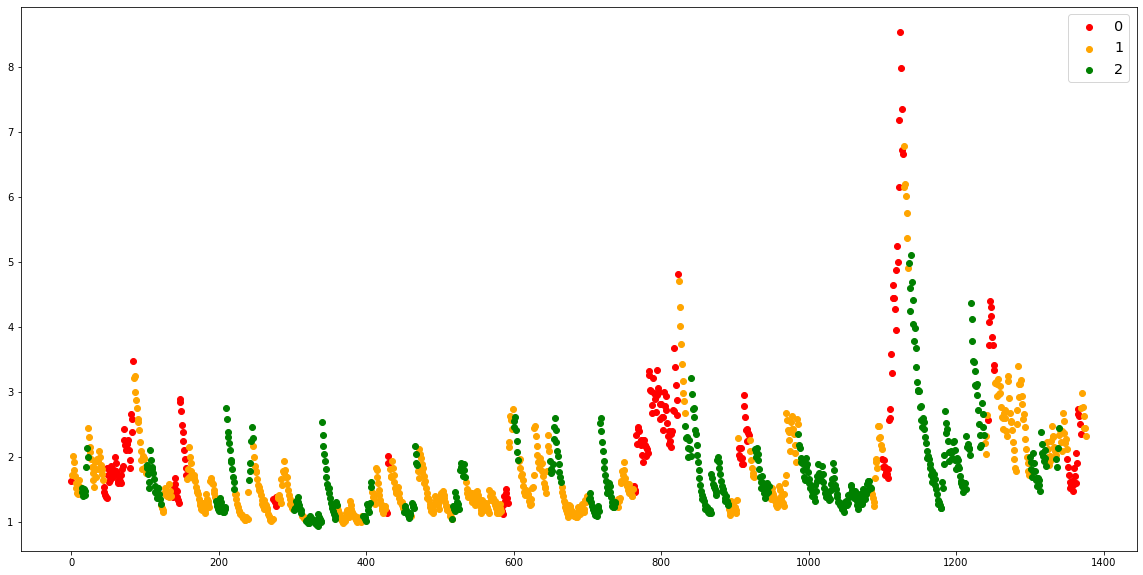

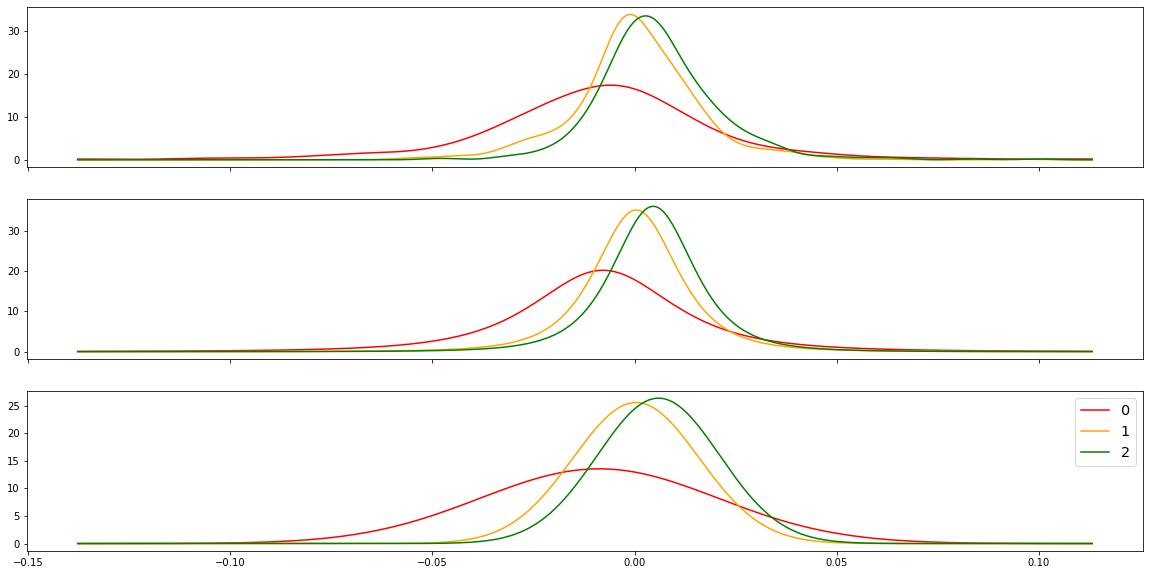

In [24]:
#Get Data
volume = stock.Volume.values[1:]
volatility = get_volatility(lr) #Must be rescaled to use in MC like standard dev.
dist_params = get_dists(lr,lb)


plot_vol(volume,lb)
#...
plot_vol(volatility,lb)
#...
plot_dists(*dist_params)



**Can see that volatility and volume traded are highest during large price drop in stock**

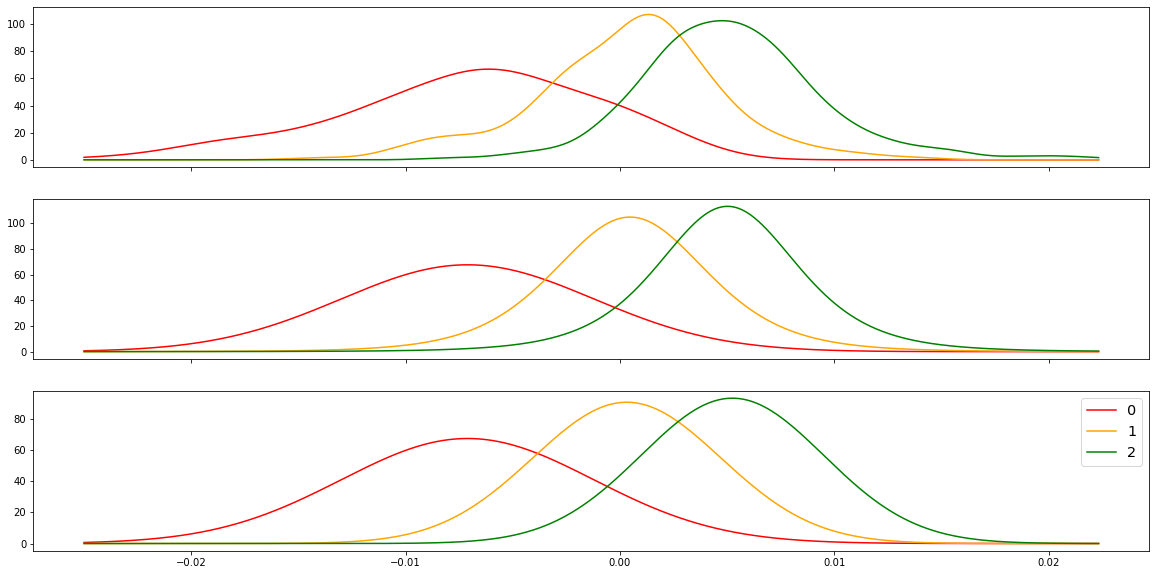

In [25]:
#using Hull Moving Average instead of EMA
def hma(c,w):
    cs = pd.Series(c)
    ema1 = 2*cs.ewm(span=w//2).mean()-cs.ewm(span=w).mean()
    hma = ema1.ewm(span=int(np.sqrt(w))).mean()
    return hma

hh = hma(c,20)
hlr = np.diff(np.log(hh.values))
dist_params2 = get_dists(hlr,lb)
plot_dists(*dist_params2)

0 9
1 21
2 16


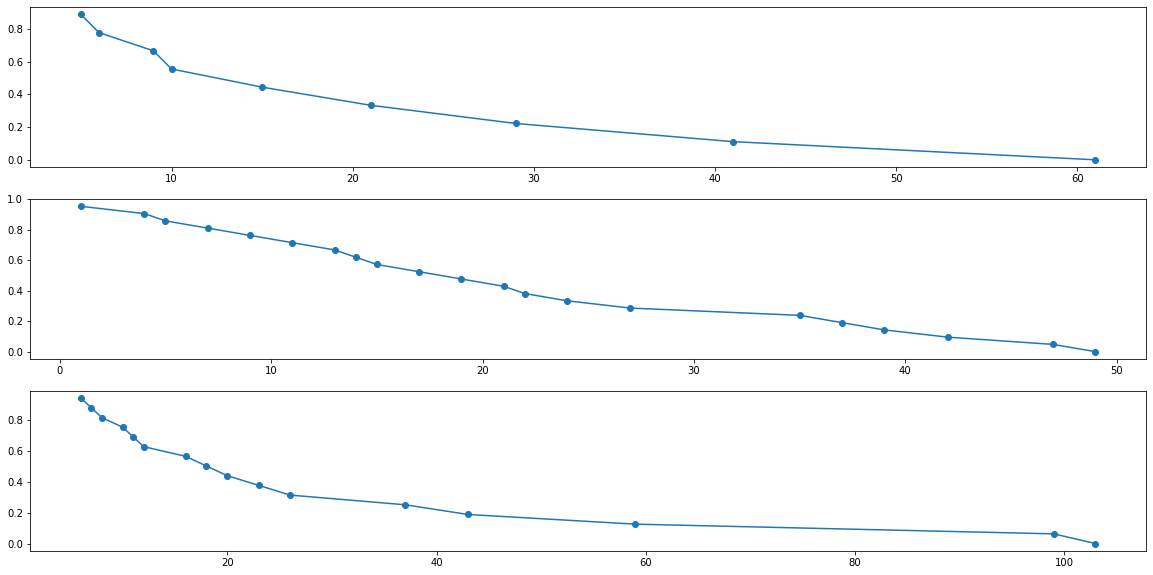

In [26]:
def get_trend_probs(lb):
    avg_tlengths = dict()
    pcts = dict()
    for i in range(3):
        idx = np.where(np.diff(np.where(lb==i)[0])!=1)[0]
        lengths = np.diff(idx)
        m = lengths[lengths>2].mean()
        avg_tlengths[str(i)] = m
        ll = np.unique(lengths)
        
        temp = []
        for x in ll:
            p = len(ll[ll>x])/len(ll)
            temp.append((x,p))
        
        pcts[str(i)] = temp
        
    #Print number of trends; If number is small, retrieve more data
    for i in range(3):
        temp = len(pcts[str(i)])
        print(i,temp)
        
    return avg_tlengths,pcts

def plot_trend_probs(pcts):
    fig,axes = plt.subplots(nrows=3,figsize=(20,10))
    for i in range(3):
        x,y = zip(*pcts[str(i)])
        axes[i].plot(x,y,marker='o')
    plt.show()

avg,pcts = get_trend_probs(lb)
plot_trend_probs(pcts)

## Monte Carlo Simulation

In [27]:
def gbm(data,tsteps,npaths):
    '''
    :type data: pandas DataFrame
    :param data: OHLCV data
    
    :type tsteps: int
    :param tsteps: Number of periods to simulate (in days)
    
    :type npaths: int
    :param npaths: Number of paths to simulate for each tstep
    
    dSt = exp(mu + sigma^2 * Wt); Wt ~ N(0,1)
    '''
    c = data.Close.values
    lr = np.diff(np.log(c))
    s0 = c[-1]
    
    mu = lr.mean()-.5*lr.var() #drift
    sigma = lr.std()
    Wt = norm.rvs(size=(npaths,tsteps))
    
    r = np.exp(mu+sigma*Wt)
    prices = np.ones(shape=(npaths,tsteps+1))
    prices[:,1:] = r
    
    prices = s0 * prices.cumprod(axis=1)

    return prices


Breaking stock data into 2 chunks and run gbm

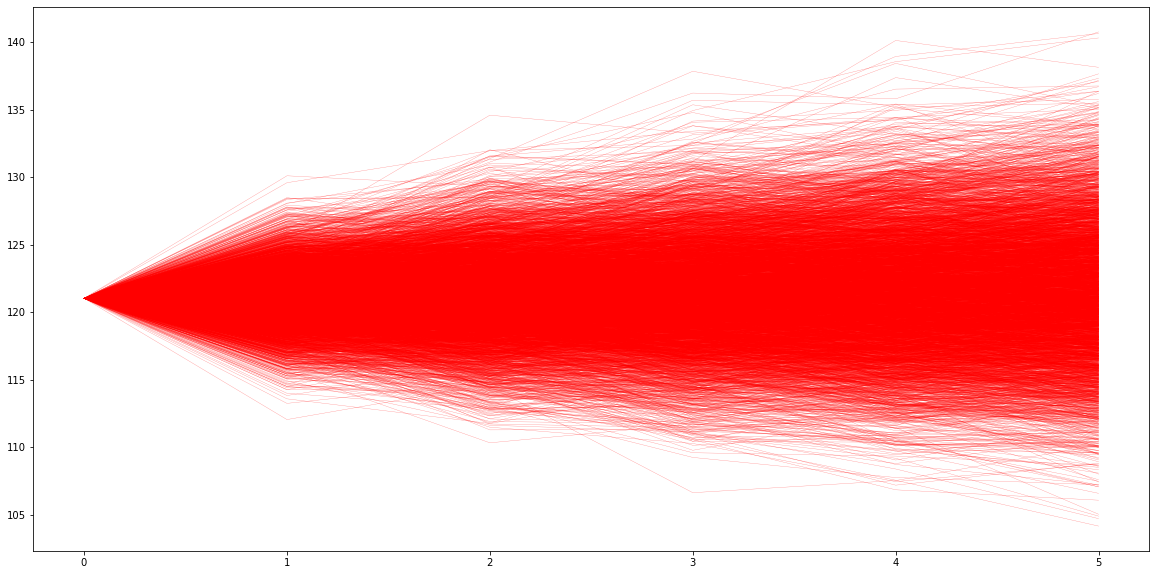

In [30]:
#aapl = dataframe of OHLCV data
a1 = stock.copy()[:-3]
a2 = stock.copy()[-4:]

prices1 = gbm(a1,5,50000)
plt.figure(figsize=(20,10))
plt.plot(prices1[::10].T,'r',linewidth=.3,alpha=.5);


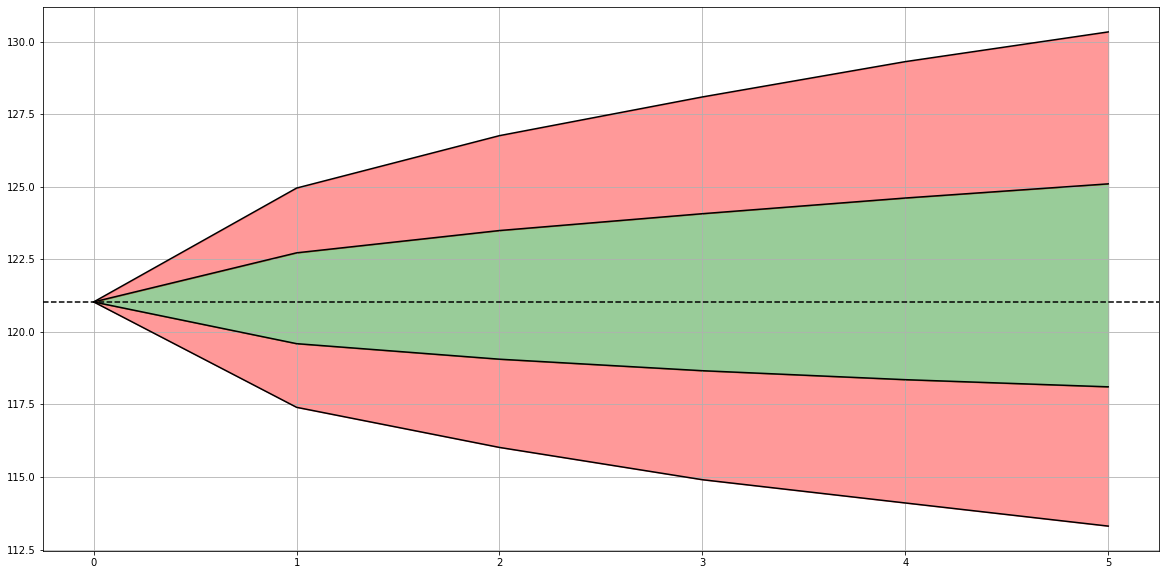

In [34]:
def prob_cone(prices,percentiles=None):
    '''
    :type prices: ndarray
    :param prices: Simulated prices for a given asset
    
    :type percentiles: None or list
    :param percentiles: Percentiles to create probability cone
    '''
    if percentiles==None:
        percentiles = [0.05,0.25,0.75,0.95]
    else:
        pass
    
    sprices = np.sort(prices,axis=0)
    pcone = np.empty(shape=(len(percentiles),prices.shape[1]))
    for i in range(len(percentiles)):
        pct = percentiles[i]
        ix = int(pct*prices.shape[0])
        pcone[i] = sprices[ix]
    return pcone

def plot_pcone(pcone):
    #Function Assumes 4 percentiles used
    plt.figure(figsize=(20,10))
    xr = np.arange(pcone.shape[1])
    [plt.plot(xr,pcone[i],color='k') for i in range(4)]
    for i in range(3):
        #Fill Between Each
        if i!=1:
            plt.fill_between(xr,pcone[i],pcone[i+1],color='r',alpha=.4)
        else:
            plt.fill_between(xr,pcone[i],pcone[i+1],color='g',alpha=.4)
    
    plt.axhline(pcone[0][0],color='k',linestyle='dashed')
    plt.grid(True)
    plt.show()

pc1 = prob_cone(prices1)
plot_pcone(pc1)